In [1]:
import sys
# !{sys.executable} -m pip install torch torchvision torchaudio
import lightgbm as lgb
import xgboost

from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
from scipy.spatial import distance_matrix

# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, MACCSkeys
from openbabel import openbabel as ob
from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 400

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [26]:
# Useful data
ptable = fetch_table('elements').set_index('symbol')
Z={v:k for k,v in ptable['atomic_number'].to_dict().items()}

In [2]:
aa_dictog={'Glycine':"O=C(O)CN",
 'Arginine':"O=C(O)[C@H](CCCNC(N)=N)N",
 'Aspartic':"O=C(O)[C@H](CC(O)=O)N",
 'Alanine':"O=C(O)[C@H](C)N",
 'Threonine':"O=C(O)[C@H]([C@H](O)C)N",
 'Phenylalanine':"O=C(O)[C@H](CC1=CC=CC=C1)N",
 'Leucine':"O=C(O)[C@H](CC(C)C)N",
 'Lysine':"O=C(O)[C@H](CCCCN)N",
 'Histidine':"O=C(O)[C@H](CC1=CNC=N1)N",
 'Cysteine':"O=C(O)[C@H](CS)N",
 'Glutamine':"O=C(O)[C@H](CCC(N)=O)N",
 'Methionine':"O=C(O)[C@H](CCSC)N",
 'Tryptophan':"O=C(O)[C@H](CC1=CNC2=CC=CC=C12)N",
 'Serine':"O=C(O)[C@H](CO)N",
 'Glutamic':"O=C(O)[C@H](CCC(O)=O)N",
 'Proline':"O=C(O)[C@H]1NCCC1",
 'Asparagine':"O=C(O)[C@H](CC(N)=O)N",
 'Valine':"O=C(O)[C@H](C(C)C)N",
 'Tyrosine':"O=C(O)[C@H](CC1=CC=C(C=C1)O)N",
 'Isoleucine':"O=C(O)[C@H]([C@@H](C)CC)N"}
aa_dict={}
for k,v in aa_dictog.items():
    mol=Chem.MolFromSmiles(v)
    Chem.RemoveStereochemistry(mol)
    aa_dict[k]=Chem.MolToSmiles(mol)


In [3]:
# Find set of files
# monomerfiles=glob('./dipeptides_coordinates/AA_AA_*/final.xyz')
co2files=glob('./dipeptides_co2_coordinates/AA_AA_*/final.xyz')
# # Name check
# co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files]
# moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles]

y=pd.read_excel('400_dipeptides_interaction_energy.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","")) for i in pd.read_excel('400_dipeptides_interaction_energy.xlsx', 'Sheet2',header=None).values]).set_index(0)

ptable = fetch_table('elements').set_index('symbol')
AAs=list(set(sum([i[0].split('-') for i in pairs.values],[])))

monomerfiles={}
for k,v in pairs.to_dict()[1].items():
    path=f'./dipeptides_coordinates/{k}/final.xyz'
    if os.path.exists(path):
        monomerfiles[v]=path

In [4]:
def genxyz(filename):
    """
    Generate xyz file as numpy arrays
    
    parameters
    ----------
    filename: str
        Path to xyz file
        
    returns
    -------
    atoms: np.ndarray (str)
    
    xyz: np.ndarray (float)
    """
    file=np.genfromtxt(filename,skip_header=2,dtype=str)

    atoms=file[:,0]
    xyz=file[:,1:].astype(float)
    
    return atoms, xyz


def gendistmat(xyz):
    """
    Generate distance matrix from xyz array
    
    parameters
    ----------
    xyz: np.ndarray
    
    returns
    -------
    D: np.ndarray
    """
    atoms=xyz[0]
    xyz=xyz[1]
    D=distance_matrix(xyz,xyz)
    D=pd.DataFrame(D)
    return atoms,D

def closest(atms,distmat):
    clsdf=distmat.iloc[-3:,:-3].T.idxmin().to_frame()
    close=atms[clsdf.values]
    clsdf['atoms']=close
    clsdf=clsdf.rename(columns={0:'idx'})
    if dict(Counter(atms[clsdf.index]))=={'C':1,'O':2}:        
        return clsdf
    else:
        return None

In [62]:
inter_dict={pairs.to_dict()[1]['_'.join(i.split('/')[-2].split('_')[:3])]:closest(*gendistmat(genxyz(i))) for i in co2files}

In [68]:

[a.GetSymbol() for a in mol.GetAtoms()]

['N',
 'C',
 'C',
 'C',
 'C',
 'C',
 'O',
 'N',
 'C',
 'C',
 'C',
 'C',
 'C',
 'O',
 'O',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H']

In [64]:
Chem.rdmolops.GetAdjacencyMatrix(mol)

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

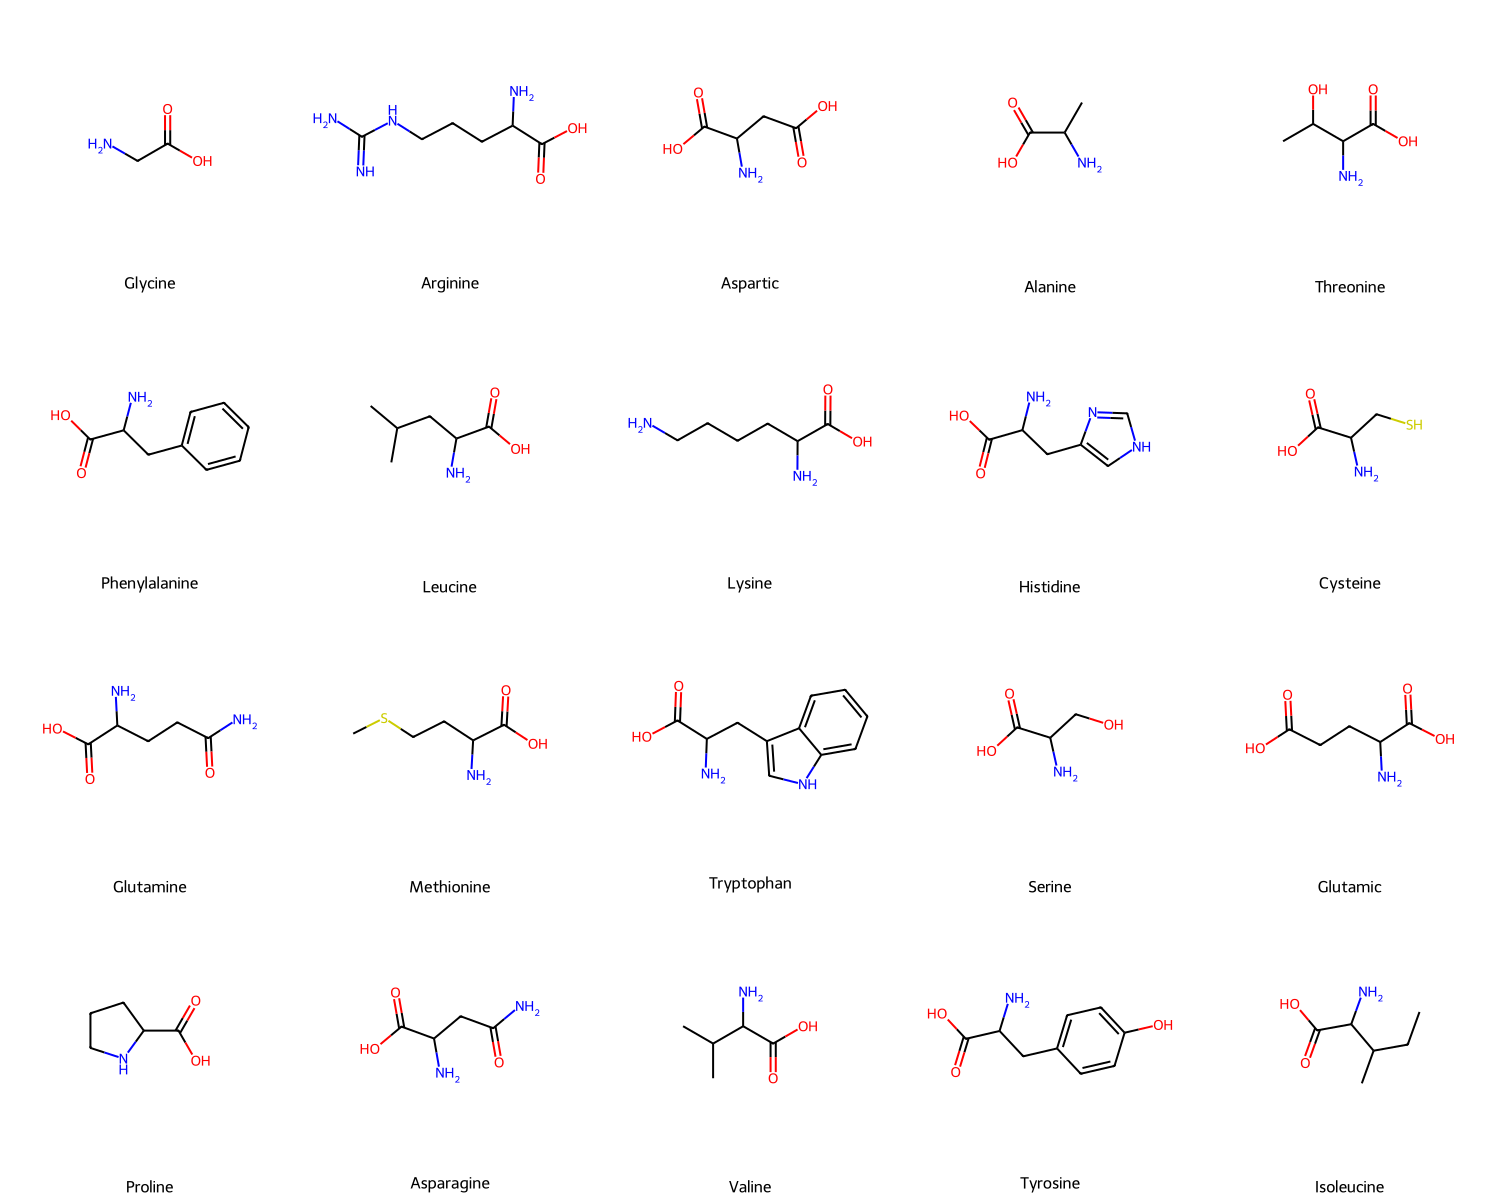

In [36]:
mols={}
for k,m in monomerfiles.items():
    mol=Chem.AddHs(Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]))
    Chem.RemoveStereochemistry(mol)
    mols[k]=mol
# Draw.MolsToGridImage(list(mols.values()),molsPerRow=20, subImgSize=(300,300),maxMols=400,legends=mols.keys())

aa_mols={k:Chem.MolFromSmiles(v) for k,v in aa_dict.items()}
Draw.MolsToGridImage(aa_mols.values(),molsPerRow=5, subImgSize=(300,300),legends=aa_mols.keys())

In [37]:

{a.GetIdx():a.GetSymbol() for a in list(mols['Alanine-Alanine'].GetAtoms())}

{0: 'N',
 1: 'C',
 2: 'C',
 3: 'C',
 4: 'O',
 5: 'N',
 6: 'C',
 7: 'C',
 8: 'C',
 9: 'O',
 10: 'O',
 11: 'H',
 12: 'H',
 13: 'H',
 14: 'H',
 15: 'H',
 16: 'H',
 17: 'H',
 18: 'H',
 19: 'H',
 20: 'H',
 21: 'H',
 22: 'H'}

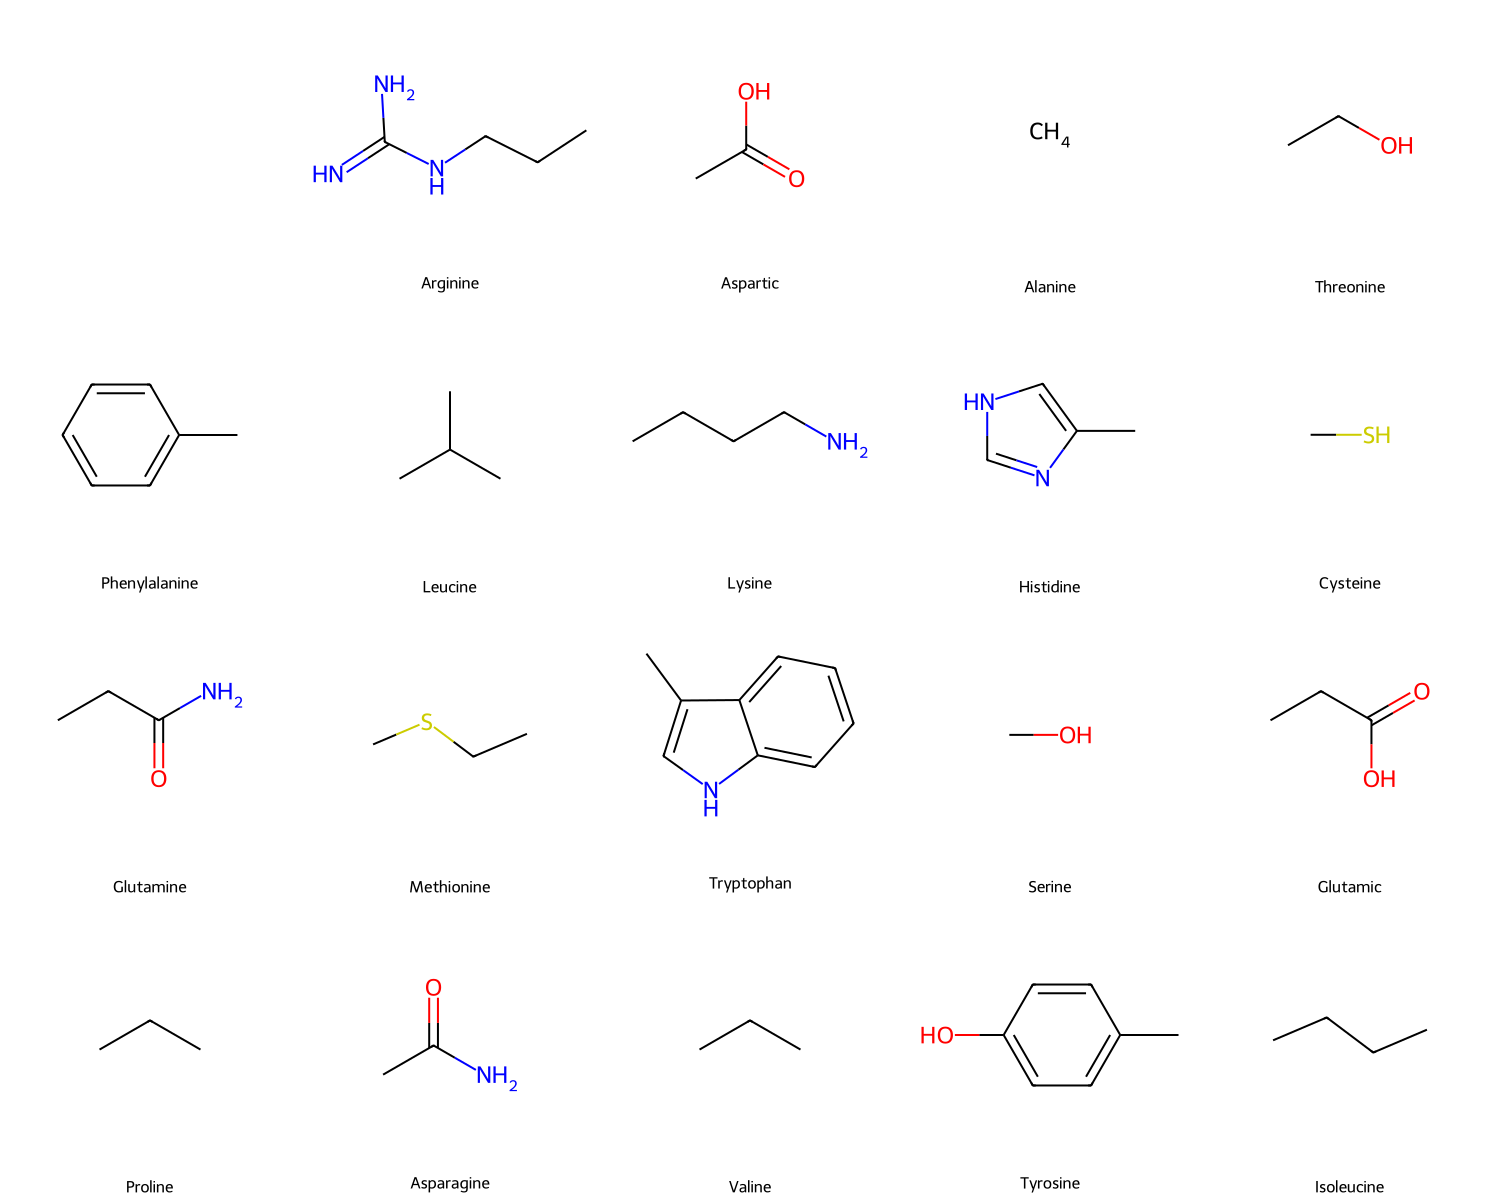

In [7]:
side_chains={k:AllChem.DeleteSubstructs(v,aa_mols['Glycine']) for k,v in aa_mols.items()}
# side_chains={k:Chem.ReplaceSubstructs(v,aa_mols['Glycine'],Chem.MolFromSmarts("*"))[0] for k,v in aa_mols.items()}
Draw.MolsToGridImage(side_chains.values(),molsPerRow=5, subImgSize=(300,300),legends=side_chains.keys())

In [9]:
interset=set(inter_dict['Glutamine-Phenylalanine']['idx'])
mol=Chem.AddHs(mols['Glutamine-Phenylalanine'])

pattchain1 = side_chains['Glutamine']
hitchain_ats1 = set(list(mol.GetSubstructMatch(pattchain1)))
pattchain2 = side_chains['Phenylalanine']
hitchain_ats2 = set(list(mol.GetSubstructMatch(pattchain2)))


pattAA1 = aa_mols['Glutamine']
hitAA_ats1 = set(list(mol.GetSubstructMatch(pattAA1)))
pattAA2 = aa_mols['Phenylalanine']
hitAA_ats2 = set(list(mol.GetSubstructMatch(pattAA2)))


if len(hitchain_ats1-set(interset))!=len(hitchain_ats1):
    print(hitchain_ats1)
    
if len(hitchain_ats2-set(interset))!=len(hitchain_ats2):
    print(hitchain_ats2)
    
if len(hitAA_ats1-set(interset))!=len(hitAA_ats1):
    print(hitAA_ats1)    
    
if len(hitAA_ats2-set(interset))!=len(hitAA_ats2):
    print(hitAA_ats2)  
    
    
    
    
    
dropOH={}
amino={}
for k,m in aa_mols.items():
    m=AllChem.AddHs(m)
    gly=set(sum(map(list,m.GetSubstructMatches(aa_mols['Glycine'])),[]))
    OHmatch=set(sum(map(list,m.GetSubstructMatches(Chem.MolFromSmarts("[OH]"))),[]))
    if k!='Proline':
        NH2match=set(sum(map(list,m.GetSubstructMatches(Chem.MolFromSmarts("[N;H2]"))),[]))
    else:
        NH2match=set(sum(map(list,m.GetSubstructMatches(Chem.MolFromSmarts("[N;H1]"))),[]))
    
    n=Chem.EditableMol(m)
    o=Chem.EditableMol(m)
    
    # Remove this one 
    if len(gly-OHmatch)!=len(gly):
        n.RemoveAtom(list(gly&OHmatch)[0])
        A = AllChem.RemoveAllHs(n.GetMol())
    # Remove one hydrogen if it is anything BUT proline
    if len(gly-NH2match)!=len(gly):
        
        o.RemoveAtom(list(gly&NH2match)[0])
        B = AllChem.RemoveAllHs(o.GetMol())
        amino[k]=list(gly&NH2match)[0]
    dropOH[k]=A
    
        

{2, 3, 4, 5, 6}


In [11]:
amino

{'Glycine': 0,
 'Arginine': 8,
 'Aspartic': 0,
 'Alanine': 2,
 'Threonine': 4,
 'Phenylalanine': 0,
 'Leucine': 5,
 'Lysine': 6,
 'Histidine': 0,
 'Cysteine': 0,
 'Glutamine': 6,
 'Methionine': 5,
 'Tryptophan': 0,
 'Serine': 0,
 'Glutamic': 0,
 'Proline': 7,
 'Asparagine': 5,
 'Valine': 4,
 'Tyrosine': 0,
 'Isoleucine': 5}

In [14]:
dropOH

{'Glycine': <rdkit.Chem.rdchem.Mol at 0x282eff2e0>,
 'Arginine': <rdkit.Chem.rdchem.Mol at 0x282eff280>,
 'Aspartic': <rdkit.Chem.rdchem.Mol at 0x282eff340>,
 'Alanine': <rdkit.Chem.rdchem.Mol at 0x282ef9fa0>,
 'Threonine': <rdkit.Chem.rdchem.Mol at 0x16d11a160>,
 'Phenylalanine': <rdkit.Chem.rdchem.Mol at 0x16d11a100>,
 'Leucine': <rdkit.Chem.rdchem.Mol at 0x16d11a0a0>,
 'Lysine': <rdkit.Chem.rdchem.Mol at 0x16d11a1c0>,
 'Histidine': <rdkit.Chem.rdchem.Mol at 0x17ae96040>,
 'Cysteine': <rdkit.Chem.rdchem.Mol at 0x16cae5040>,
 'Glutamine': <rdkit.Chem.rdchem.Mol at 0x16cae50a0>,
 'Methionine': <rdkit.Chem.rdchem.Mol at 0x16cae5100>,
 'Tryptophan': <rdkit.Chem.rdchem.Mol at 0x17ae960a0>,
 'Serine': <rdkit.Chem.rdchem.Mol at 0x16cae5160>,
 'Glutamic': <rdkit.Chem.rdchem.Mol at 0x16cae51c0>,
 'Proline': <rdkit.Chem.rdchem.Mol at 0x282cd09a0>,
 'Asparagine': <rdkit.Chem.rdchem.Mol at 0x282cd0940>,
 'Valine': <rdkit.Chem.rdchem.Mol at 0x282cd08e0>,
 'Tyrosine': <rdkit.Chem.rdchem.Mol at 0x2

In [ ]:
Draw.MolsToGridImage(dipeptide_split['Glycine'].values())